In [1]:
#!/usr/bin/env python3.6
# -*- coding: utf-8 -*-

In [2]:
# Imports
import sys
import joblib
import numpy as np
from matplotlib import animation
from IPython.display import HTML
from matplotlib import pyplot as plt
import mpl_toolkits.mplot3d.axes3d as p3

In [3]:
#np.random.seed(20)
np.set_printoptions(threshold=sys.maxsize)

In [4]:
%matplotlib inline

In [5]:
%store -r X_motion_step
%store -r Y_motion_step
print(X_motion_step.shape)
print(Y_motion_step.shape)

(148884, 37)
(148884, 8)


# Multivariate Linear Regression (Foot prediction)

The input will use initially only:

- **HighCmd: fwd, side, rot speeds**
- **HighState: fwd, side, rot speeds, footPosition2Body (FR)**

and as output we seek to predict the following:

- **footPosition2Body (FR)**

In [6]:
import sklearn
from sklearn import metrics
from sklearn.feature_selection import RFE
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [7]:
# Entries where FL foot is swinging
idx_rr_swinging = np.where(X_motion_step[:, 25] == 1)[0]
X_motion_step_RR = X_motion_step[idx_rr_swinging]
Y_motion_step_RR = Y_motion_step[idx_rr_swinging]

## Predict RR foot -> x

In [8]:
X_motion_step_RR[0, :]

array([ 1.00000000e-01,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.35253631e-02, -5.45018454e-03,
        1.90322078e-37, -5.57888703e-24, -4.46281599e-23,  9.45164094e-02,
        1.59093827e-01,  1.32301375e-01, -3.42030436e-01,  2.06204250e-01,
       -1.36616319e-01, -3.38554084e-01, -2.68098682e-01,  1.39270037e-01,
       -3.41048896e-01, -2.74800837e-01, -1.31081313e-01, -3.37453157e-01,
        0.00000000e+00,  1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        1.58638060e-02, -4.57940996e-03,  2.44542360e-02,  1.46174431e-03,
        0.00000000e+00,  0.00000000e+00,  1.09132966e-01,  3.01721154e-03,
        3.34074736e-01])

In [9]:
Y_motion_step_RR[0, :]

array([ 0.07464571, -0.00153224,  0.        ,  0.        ,  0.        ,
        0.        ,  0.03709272, -0.01009694])

In [10]:
Y_motion_step_RR.shape

(73115, 8)

In [11]:
#X_motion_step[idx_rr_swinging - 1, 28]

### Linear Regression

In [18]:
# Input
#X = np.hstack((X_motion_step_RR[:, :2], np.array([X_motion_step_RR[:, 5]]).T, 
#               X_motion_step_RR[:, 6:8], np.array([X_motion_step_RR[:, 11]]).T, 
#               np.array([X_motion_step_RR[:, 18]]).T, np.array([X_motion_step_RR[:, 21]]).T))
X = np.hstack((X_motion_step_RR[:, :2], np.array([X_motion_step_RR[:, 5]]).T, 
               np.array([X_motion_step_RR[:, 18]]).T, np.array([X_motion_step_RR[:, 21]]).T))

X = np.hstack((X_motion_step_RR[:, :2], 
               np.array([X_motion_step_RR[:, 5]]).T,
               np.array([X_motion_step[idx_rr_swinging-1, 32]]).T, 
               np.array([X_motion_step[idx_rr_swinging, 30]]).T,
               X_motion_step[idx_rr_swinging, 34:36]))

# Labels
Y = np.array([Y_motion_step_RR[:, 6]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_rr_x = LinearRegression()

# Fit the model
model_rr_x.fit(X_train, Y_train)

# Predict
predictions = model_rr_x.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9766891550036668
RMSE:  0.015579177750051404
The lowest error is:  4.817749112880076e-07
The highest error is:  0.12288691087938514
The avg. error is:  0.010670973097656128


Text(0, 0.5, 'Predictions')

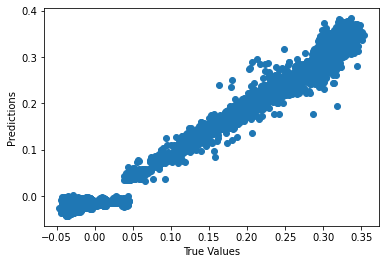

In [19]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [20]:
%store model_rr_x

Stored 'model_rr_x' (LinearRegression)


In [15]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [16]:
# Save model
joblib.dump(model_rr_x, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_rr_x.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_rr_x.sav']

### Predict RR foot -> y

In [21]:
# Input
#X = np.hstack((X_motion_step_RR[:, :2], np.array([X_motion_step_RR[:, 5]]).T, 
#               X_motion_step_RR[:, 6:8], np.array([X_motion_step_RR[:, 11]]).T, 
#               np.array([X_motion_step_RR[:, 19]]).T, np.array([X_motion_step_RR[:, 22]]).T))
X = np.hstack((X_motion_step_RR[:, :2], np.array([X_motion_step_RR[:, 5]]).T, 
               np.array([X_motion_step_RR[:, 19]]).T, np.array([X_motion_step_RR[:, 22]]).T))

X = np.hstack((X_motion_step_RR[:, :2], 
               np.array([X_motion_step_RR[:, 5]]).T,
               np.array([X_motion_step[idx_rr_swinging-1, 33]]).T, 
               np.array([X_motion_step[idx_rr_swinging, 31]]).T,
               X_motion_step[idx_rr_swinging, 34:36]))

# Labels
Y = np.array([Y_motion_step_RR[:, 7]]).T

assert Y.shape[0] == X.shape[0]

# Split data into train and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size = 0.8, test_size=0.2, shuffle=True, random_state=100)

# Create the model
model_rr_y = LinearRegression()

# Fit the model
model_rr_y.fit(X_train, Y_train)

# Predict
predictions = model_rr_y.predict(X_test)

# Stats
print('R2: ', r2_score(predictions, Y_test))
print('RMSE: ', np.sqrt(mean_squared_error(Y_test, predictions)))
print("The lowest error is: ", np.min(np.abs(predictions - Y_test)))
print("The highest error is: ", np.max(np.abs(predictions - Y_test)))
print("The avg. error is: ", np.mean(np.abs(predictions - Y_test)))
#print("Seq of errors (descendant): \n", sorted(np.abs(predictions - Y_test).tolist(), reverse=True))

R2:  0.9838478551544512
RMSE:  0.012830309782943857
The lowest error is:  2.8691205066280756e-08
The highest error is:  0.1303148847724932
The avg. error is:  0.007970547887481671


Text(0, 0.5, 'Predictions')

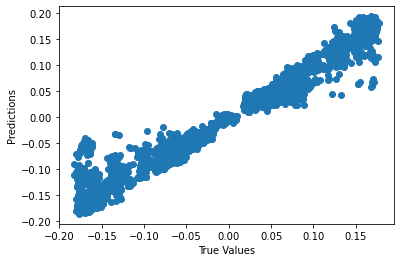

In [22]:
## The line / model
plt.scatter(Y_test, predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")

In [23]:
%store model_rr_y

Stored 'model_rr_y' (LinearRegression)


In [20]:
#for idx, prediction in enumerate(predictions):
#    print(f'Groundtruth: {Y_test[idx]}. Predicted: {prediction}')

In [21]:
# Save model
joblib.dump(model_rr_y, "/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_rr_y.sav")

['/home/itaouil/workspace/aliengo_ws/src/aliengo_navigation/models/protocol3/model_rr_y.sav']